测试数据和训练数据分组，数据分batch

In [29]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


定义CNN-LSTM 分类网络架构

In [30]:
# 定义 CNNLSTM 分类模型
class CNNLSTMclassifier(nn.Module):
    def __init__(self, input_dim, conv_archs,hidden_layer_sizes,output_dim, dropout_rate=0.5):
        """
        分类任务  params:
        input_dim        : 输入数据的维度
        conv_archs       : cnn 网络结构
        hidden_layer_size: lstm隐藏层的数目和维度
        output_dim       : 输出的维度
        dropout_rate     : 随机丢弃神经元的概率
        """
        super().__init__()
        # 批次量大小
        # CNN参数
        self.conv_arch = conv_archs # cnn网络结构
        self.input_channels = input_dim # 输入通道数
        self.cnn_features = self.make_layers()

        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层LSTM   
        self.lstm_layers.append(nn.LSTM(conv_archs[-1][-1], hidden_layer_sizes[0], batch_first=True))
        # 定义后续的LSTM层
        for i in range(1, self.num_layers):
                self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1], hidden_layer_sizes[i], batch_first=True))
        
          # 平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # 定义全连接层
        self.classifier = nn.Linear(hidden_layer_sizes[-1], output_dim)
    
     # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    def forward(self, input_seq): 
        # CNN 卷积池化操作
        #改变输入形状，适应网络输入[batch,H_in, seq_length]
        batch_size = input_seq.size(0)
        input_seq = input_seq.view(batch_size, 1, 1024)
        cnn_features = self.cnn_features(input_seq) # torch.Size([64, 128, 128])

        # 送入LSTM层
        #改变输入形状，适应网络输入[batch, seq_length, H_in]
        lstm_out = torch.transpose(cnn_features, 1, 2)  # 反转维度 和序列长度 ，适应网络输入形状
        for lstm in self.lstm_layers:
            lstm_out, _= lstm(lstm_out)  ## 进行一次LSTM层的前向传播
        # print(lstm_out.size())  # torch.Size([64, 128, 64])
        x = self.avgpool(lstm_out.transpose(1, 2))  # B C 1  torch.Size([64, 64, 1])
        flat_tensor = x.reshape(batch_size, -1) # torch.Size([64, 64])
        out = self.classifier(flat_tensor) # torch.Size([64, 5] 
        return out


输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([32, 1024])    torch.Size([32])

In [31]:
# 定义模型参数
input_dim = 1  # 输入维度为1
conv_archs = ((1, 32), (1, 64), (1, 128))   # CNN 层卷积池化结构  类似VGG
hidden_layer_sizes = [128,64]  # LSTM 层数  每层 神经元个数
output_dim = 5  # 分类数

model = CNNLSTMclassifier(input_dim, conv_archs, hidden_layer_sizes, output_dim)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    96
    32
  6144
    64
 24576
   128
 65536
 65536
   512
   512
 32768
 16384
   256
   256
   320
     5
______
213125


In [32]:
print(model)

CNNLSTMclassifier(
  (cnn_features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm_layers): ModuleList(
    (0): LSTM(128, 128, batch_first=True)
    (1): LSTM(128, 64, batch_first=True)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=64, out_features=5, bias=True)
)


### 输入为1

Epoch 1/100
Train Loss: 1.3095 Acc: 0.4364
Val Loss: 1.1021 Acc: 0.4966

Epoch 2/100
Train Loss: 0.7125 Acc: 0.7341
Val Loss: 0.7301 Acc: 0.6481

Epoch 3/100
Train Loss: 0.4986 Acc: 0.7943
Val Loss: 1.2808 Acc: 0.4795

Epoch 4/100
Train Loss: 0.3873 Acc: 0.8739
Val Loss: 1.3136 Acc: 0.5635

Epoch 5/100
Train Loss: 0.2597 Acc: 0.9316
Val Loss: 1.8619 Acc: 0.4184

Epoch 6/100
Train Loss: 0.2166 Acc: 0.9395
Val Loss: 1.8437 Acc: 0.4648

Epoch 7/100
Train Loss: 0.1529 Acc: 0.9574
Val Loss: 1.7421 Acc: 0.5220

Epoch 8/100
Train Loss: 0.1239 Acc: 0.9636
Val Loss: 0.3793 Acc: 0.8446

Epoch 9/100
Train Loss: 0.1211 Acc: 0.9636
Val Loss: 2.6723 Acc: 0.3915

Epoch 10/100
Train Loss: 0.0977 Acc: 0.9691
Val Loss: 0.8237 Acc: 0.7889

Epoch 11/100
Train Loss: 0.0809 Acc: 0.9736
Val Loss: 1.9841 Acc: 0.5860

Epoch 12/100
Train Loss: 0.0795 Acc: 0.9756
Val Loss: 1.6711 Acc: 0.6799

Epoch 13/100
Train Loss: 0.0695 Acc: 0.9764
Val Loss: 2.4540 Acc: 0.5044

Epoch 14/100
Train Loss: 0.0593 Acc: 0.9798
Val

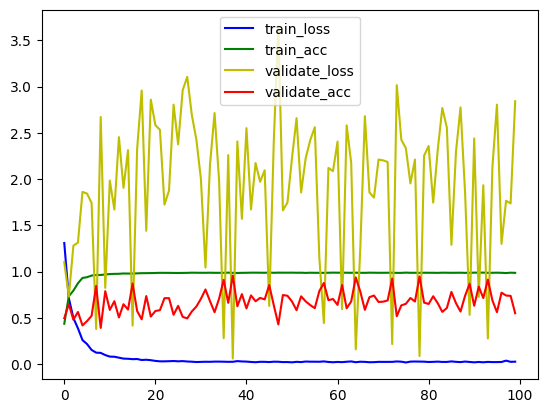

    96
    32
    32
    32
  3072
    32
    32
    32
  3072
    32
    32
    32
  3072
    32
    32
    32
  6144
    64
    64
    64
 12288
    64
    64
    64
 32768
 65536
   512
   512
 32768
 16384
   256
   256
  8192
  4096
   128
   128
  2048
    64
   320
     5
______
192485
Best Validation Accuracy: 0.9570


In [34]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# 参数配置
torch.manual_seed(100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据加载函数（添加归一化）
def dataloader(batch_size, workers=2):
    # 加载原始数据
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 数据标准化
    data_mean = train_xdata.mean()
    data_std = train_xdata.std()
    
    def normalize(data):
        return (data - data_mean) / data_std

    # 转换数据格式
    train_xdata = torch.FloatTensor(normalize(train_xdata))
    train_ylabel = torch.LongTensor(train_ylabel)
    val_xdata = torch.FloatTensor(normalize(val_xdata))
    val_ylabel = torch.LongTensor(val_ylabel)
    test_xdata = torch.FloatTensor(normalize(test_xdata))
    test_ylabel = torch.LongTensor(test_ylabel)

    # 创建DataLoader
    train_loader = Data.DataLoader(Data.TensorDataset(train_xdata, train_ylabel),
                                  batch_size=batch_size, shuffle=True, 
                                  num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(Data.TensorDataset(val_xdata, val_ylabel),
                                batch_size=batch_size, shuffle=False,
                                num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(Data.TensorDataset(test_xdata, test_ylabel),
                                 batch_size=batch_size, shuffle=False,
                                 num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

# 改进的CNN-LSTM模型
class CNNLSTMclassifier(nn.Module):
    def __init__(self, input_dim, conv_archs, hidden_layer_sizes, output_dim, dropout_rate=0.3):
        super().__init__()
        # CNN部分
        self.conv_arch = conv_archs
        self.input_channels = input_dim
        self.cnn_features = self.make_conv_layers()
        
        # LSTM部分
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # 初始化LSTM层
        for i in range(self.num_layers):
            input_size = conv_archs[-1][1] if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_size, hidden_layer_sizes[i], batch_first=True))
            if i < self.num_layers - 1:
                self.dropouts.append(nn.Dropout(dropout_rate))
        
        # 分类层
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # CNN权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # LSTM权重初始化
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_normal_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def make_conv_layers(self):
        layers = []
        in_channels = self.input_channels
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(inplace=True)
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        # CNN处理
        x = x.view(batch_size, 1, -1)  # [B, 1, 1024]
        cnn_features = self.cnn_features(x)  # [B, C, L]
        
        # LSTM处理
        lstm_input = cnn_features.permute(0, 2, 1)  # [B, L, C]
        for i in range(self.num_layers):
            lstm_input, _ = self.lstm_layers[i](lstm_input)
            if i < self.num_layers - 1:
                lstm_input = self.dropouts[i](lstm_input)
        
        # 分类处理
        x = self.avgpool(lstm_input.permute(0, 2, 1))  # [B, C, 1]
        x = x.view(batch_size, -1)
        return self.classifier(x)

# 训练函数优化
def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)
    
    best_accuracy = 0.0
    train_loss, train_acc = [], []
    validate_loss, validate_acc = [], []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0.0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += loss_function(outputs, labels).item() * inputs.size(0)
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()
        
        # 计算指标
        train_epoch_loss = epoch_loss / len(train_loader.dataset)
        train_epoch_acc = correct / len(train_loader.dataset)
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / len(val_loader.dataset)
        
        # 更新学习率
        scheduler.step(val_epoch_acc)
        
        # 记录指标
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        validate_loss.append(val_epoch_loss)
        validate_acc.append(val_epoch_acc)
        
        # 保存最佳模型
        if val_epoch_acc > best_accuracy:
            best_accuracy = val_epoch_acc
            torch.save(model, 'best_model_cnn_lstm.pt')
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n')
    
    #print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 

    def count_parameters(model):
        params = [p.numel() for p in model.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>6}')
        print(f'______\n{sum(params):>6}')
        print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    count_parameters(model)

# 参数配置
batch_size = 64
epochs = 100
input_dim = 1
#conv_archs = ((2, 32), (2, 64), (2, 128))  # 改进的CNN结构
conv_archs = ((2, 32), (2, 32), (2, 64))  # 改进的CNN结构
#hidden_layer_sizes = [128, 64]            # 增强LSTM容量
hidden_layer_sizes = [128, 64, 32]
output_dim = 5

# 初始化模型
model = CNNLSTMclassifier(input_dim, conv_archs, hidden_layer_sizes, output_dim)
loss_function = nn.CrossEntropyLoss(reduction='mean')  # 修正损失函数
learn_rate = 0.0003
optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=1e-4)

# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

# 开始训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [35]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_lstm.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    #for test_data, test_label in test_loader:
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8544\1448011076.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_cnn_lstm.pt')


              precision    recall  f1-score   support

           0     1.0000    0.9746    0.9871       197
           1     0.9635    0.9840    0.9737       188
           2     1.0000    0.9789    0.9894       190
           3     0.9692    0.9844    0.9767       192
           4     0.9744    0.9845    0.9794       193

    accuracy                         0.9812       960
   macro avg     0.9814    0.9813    0.9813       960
weighted avg     0.9816    0.9812    0.9813       960



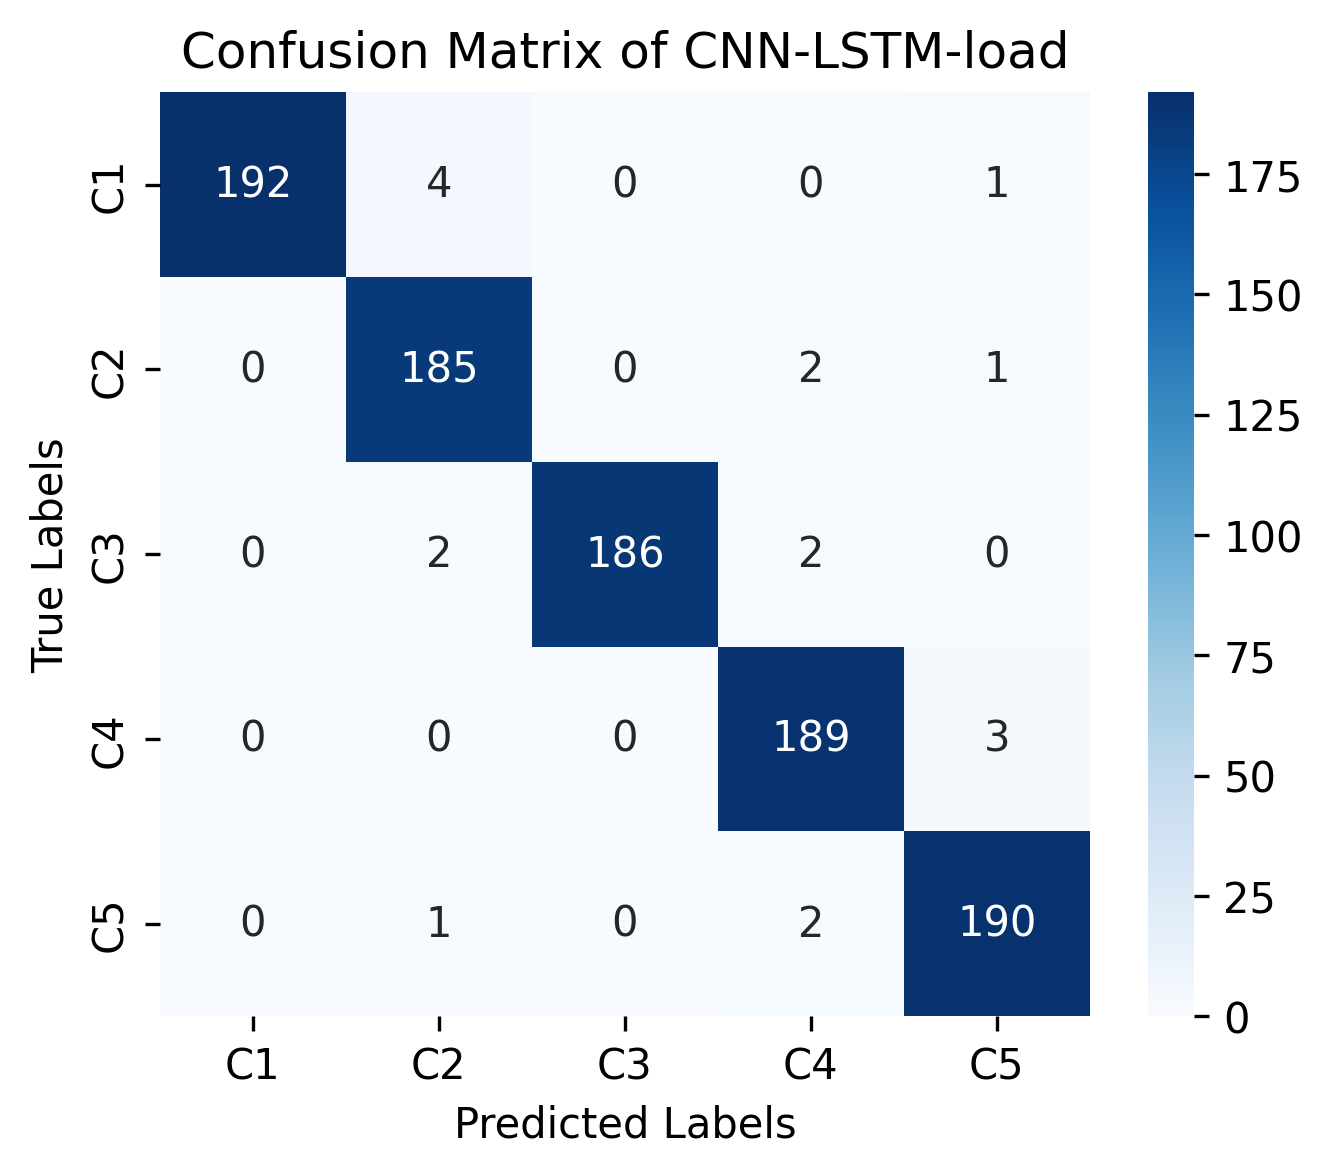

In [36]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    #5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of CNN-LSTM-load')
plt.savefig("CNN-LSTM_confusion.png")
plt.show()

### 输入为32